In [1]:
!pip install timm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.6 MB/s eta 0:00:00:00:0100:01


In [2]:
# Core Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tempfile import TemporaryDirectory
from tqdm import tqdm

# PyTorch and Torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import timm
import onnx

# Sklearn for metrics and splitting
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support

# KaggleHub: for fetching datasets easily
import kagglehub

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)
cudnn.benchmark = True  # Speed up training when input sizes are consistent

In [3]:
# Download dataset
path = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/plantvillage-dataset


In [4]:
dir_path = "/kaggle/input/plantvillage-dataset/color"

In [5]:
# Download and define the second dataset (plantextend)
extend_path = kagglehub.dataset_download("veldoratempesti/plantextend")
extend_dir_path = os.path.join(extend_path, "full")  # Matches your screenshot

# Store image file paths and labels
merged_image_paths = []
merged_label_names = []
all_labels_set = set()

def collect_image_paths(base_dir):
    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder)
        if not os.path.isdir(folder_path):
            continue
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            if img_name.lower().endswith((".png", ".jpg", ".jpeg")):
                merged_image_paths.append(img_path)
                merged_label_names.append(folder)
                all_labels_set.add(folder)

# Collect image paths from both datasets
collect_image_paths(dir_path)          # From plantvillage color
collect_image_paths(extend_dir_path)   # From plantextend/full

# Final label-to-index mapping
distinct_labels = sorted(all_labels_set)

# Encode labels numerically
labels = np.array([distinct_labels.index(name) for name in merged_label_names])
image_paths = np.array(merged_image_paths)

In [6]:
# Save label -> index mapping
with open("labels.txt", "w") as f:
    for idx, label in enumerate(distinct_labels):
        f.write(f"{idx}\t{label}\n")

In [7]:
# Display the shape of the data and labels arrays
print(f"Total images: {len(image_paths)}")
print(f"Unique classes: {len(distinct_labels)}")
print(f"Example label → index: {distinct_labels[0]} → 0")

Total images: 55589
Unique classes: 38
Example label → index: Apple___Apple_scab → 0


In [8]:
# Convert label names to numeric indices
labels = np.array([distinct_labels.index(name) for name in merged_label_names])

# Display numeric labels
print("Numeric labels:", labels)

Numeric labels: [30 30 30 ... 10 10 10]


In [9]:
# Check CUDA availability
is_cuda_available = torch.cuda.is_available()
print("CUDA Available:", is_cuda_available)

CUDA Available: True


In [10]:
from sklearn.model_selection import train_test_split

# New: split using image_paths and labels
X_train, X_temp, y_train, y_temp = train_test_split(image_paths, labels, test_size=0.20, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.10, random_state=42, stratify=y_temp)

In [11]:
from PIL import Image

class PlantVillageLazyDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, target_transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]

        try:
            image = Image.open(image_path).convert("RGB")
            if image.mode == 'P':
                image = image.convert('RGBA').convert('RGB')
        except Exception as e:
            print(f"⚠️ Error reading image {image_path}: {e}")
            raise e

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [12]:
# Data augmentation and preprocessing
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), shear=10),
        transforms.ColorJitter(0.3, 0.3, 0.3, 0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ]),
}

# Data loaders
# ✅ UPDATE this block:
loaders = {
    'train': DataLoader(
        PlantVillageLazyDataset(X_train, y_train, transform=data_transforms['train']),
        shuffle=True, batch_size=32
    ),
    'val': DataLoader(
        PlantVillageLazyDataset(X_val, y_val, transform=data_transforms['val']),
        shuffle=False, batch_size=32
    ),
    'test': DataLoader(
        PlantVillageLazyDataset(X_test, y_test, transform=data_transforms['val']),
        shuffle=False, batch_size=32
    )
}

dataset_sizes = {
    'train': len(X_train),
    'val': len(X_val),
    'test': len(X_test)
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
losses = {'train': [], 'val': []}
accs = {'train': [], 'val': []}

In [13]:
def train(model, criterion, optimizer, scheduler):
    model.train()
    total_loss = 0.0
    total_correct = 0

    for inputs, labels in tqdm(loaders['train'], desc="Training"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.enable_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        total_correct += torch.sum(preds == labels)

    scheduler.step()

    train_loss = total_loss / dataset_sizes['train']
    train_acc = total_correct.cpu().item() / dataset_sizes['train']

    losses['train'].append(train_loss)
    accs['train'].append(train_acc)

    return train_loss, train_acc

In [14]:
def val(model, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0

    for inputs, labels in loaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)
            loss = criterion(outputs, labels)

        total_loss += loss.item() * inputs.size(0)
        total_correct += torch.sum(preds == labels)

    val_loss = total_loss / dataset_sizes['val']
    val_acc = total_correct.cpu().item() / dataset_sizes['val']

    losses['val'].append(val_loss)
    accs['val'].append(val_acc)

    return val_loss, val_acc

In [15]:
def test(model, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    true_labels = []
    pred_labels = []

    for inputs, labels in loaders['test']:
        inputs = inputs.to(device)
        true_labels.extend(labels.numpy())
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)
            pred_labels.extend(preds.cpu().numpy())
            loss = criterion(outputs, labels)

        total_loss += loss.item() * inputs.size(0)
        total_correct += torch.sum(preds == labels)

    test_loss = total_loss / dataset_sizes['test']
    test_acc = total_correct.cpu().item() / dataset_sizes['test']
    conf_matrix = confusion_matrix(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')

    return test_loss, test_acc, conf_matrix, precision, recall, f1

In [16]:
# Load pretrained ConvNeXt-Tiny model
model = timm.create_model('convnext_tiny', pretrained=True, num_classes=len(distinct_labels))

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

In [17]:
# Move model to device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [18]:
# Training configuration
num_epochs = 25
best_acc = 0.0

# Save initial model state
torch.save(model.state_dict(), 'convnext_model.pt')

# Training loop
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}')
    print('-' * 30)

    train_loss, train_acc = train(model, criterion, optimizer, scheduler)
    val_loss, val_acc = val(model, criterion)

    print(f'Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}')
    print(f'Validation Loss: {val_loss:.4f} | Acc: {val_acc:.4f}')

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'epoch': epoch,
            'best_acc': best_acc,
        }, 'checkpoint.pt')
        
        # Save best model weights for inference
        torch.save(model.state_dict(), 'convnext_model.pt')

print(f'\nBest Validation Accuracy Achieved: {best_acc:.4f}')

# Reload the best weights (just in case final epoch wasn’t the best)
model.load_state_dict(torch.load('convnext_model.pt'))

# Export to ONNX
torch.onnx.export(
    model, 
    torch.randn(1, 3, 256, 256).to(device),  # Dummy input tensor
    "convnext_model.onnx", 
    export_params=True, 
    opset_version=11, 
    input_names=['input'], 
    output_names=['output']
)

print("✅ Model successfully exported to ONNX format as 'convnext_model.onnx'")


Epoch 1/25
------------------------------


Training: 100%|██████████| 1390/1390 [24:16<00:00,  1.05s/it]
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 3.1827 | Acc: 0.1675
Validation Loss: 2.7036 | Acc: 0.2749

Epoch 2/25
------------------------------


Training: 100%|██████████| 1390/1390 [21:11<00:00,  1.09it/s]


Train Loss: 2.0436 | Acc: 0.4203
Validation Loss: 1.0554 | Acc: 0.6874

Epoch 3/25
------------------------------


Training: 100%|██████████| 1390/1390 [20:10<00:00,  1.15it/s]


Train Loss: 0.9758 | Acc: 0.7049
Validation Loss: 0.6735 | Acc: 0.7872

Epoch 4/25
------------------------------


Training: 100%|██████████| 1390/1390 [20:03<00:00,  1.16it/s]


Train Loss: 0.6311 | Acc: 0.8065
Validation Loss: 0.4342 | Acc: 0.8731

Epoch 5/25
------------------------------


Training: 100%|██████████| 1390/1390 [20:08<00:00,  1.15it/s]


Train Loss: 0.4755 | Acc: 0.8523
Validation Loss: 0.3253 | Acc: 0.9023

Epoch 6/25
------------------------------


Training: 100%|██████████| 1390/1390 [19:55<00:00,  1.16it/s]


Train Loss: 0.3859 | Acc: 0.8803
Validation Loss: 0.3136 | Acc: 0.9079

Epoch 7/25
------------------------------


Training: 100%|██████████| 1390/1390 [19:45<00:00,  1.17it/s]


Train Loss: 0.3274 | Acc: 0.8979
Validation Loss: 0.2656 | Acc: 0.9213

Epoch 8/25
------------------------------


Training: 100%|██████████| 1390/1390 [19:53<00:00,  1.16it/s]


Train Loss: 0.1683 | Acc: 0.9488
Validation Loss: 0.1505 | Acc: 0.9561

Epoch 9/25
------------------------------


Training: 100%|██████████| 1390/1390 [20:04<00:00,  1.15it/s]


Train Loss: 0.1421 | Acc: 0.9587
Validation Loss: 0.1534 | Acc: 0.9565

Epoch 10/25
------------------------------


Training: 100%|██████████| 1390/1390 [20:03<00:00,  1.15it/s]


Train Loss: 0.1293 | Acc: 0.9614
Validation Loss: 0.1401 | Acc: 0.9616

Epoch 11/25
------------------------------


Training: 100%|██████████| 1390/1390 [20:14<00:00,  1.14it/s]


Train Loss: 0.1210 | Acc: 0.9633
Validation Loss: 0.1400 | Acc: 0.9608

Epoch 12/25
------------------------------


Training: 100%|██████████| 1390/1390 [20:02<00:00,  1.16it/s]


Train Loss: 0.1126 | Acc: 0.9654
Validation Loss: 0.1466 | Acc: 0.9584

Epoch 13/25
------------------------------


Training: 100%|██████████| 1390/1390 [20:05<00:00,  1.15it/s]


Train Loss: 0.1060 | Acc: 0.9679
Validation Loss: 0.1311 | Acc: 0.9639

Epoch 14/25
------------------------------


Training: 100%|██████████| 1390/1390 [20:02<00:00,  1.16it/s]


Train Loss: 0.0991 | Acc: 0.9695
Validation Loss: 0.1343 | Acc: 0.9630

Epoch 15/25
------------------------------


Training: 100%|██████████| 1390/1390 [20:22<00:00,  1.14it/s]


Train Loss: 0.0823 | Acc: 0.9756
Validation Loss: 0.1235 | Acc: 0.9663

Epoch 16/25
------------------------------


Training: 100%|██████████| 1390/1390 [20:42<00:00,  1.12it/s]


Train Loss: 0.0780 | Acc: 0.9769
Validation Loss: 0.1225 | Acc: 0.9668

Epoch 17/25
------------------------------


Training: 100%|██████████| 1390/1390 [20:06<00:00,  1.15it/s]


Train Loss: 0.0782 | Acc: 0.9766
Validation Loss: 0.1241 | Acc: 0.9680

Epoch 18/25
------------------------------


Training: 100%|██████████| 1390/1390 [20:13<00:00,  1.15it/s]


Train Loss: 0.0765 | Acc: 0.9768
Validation Loss: 0.1237 | Acc: 0.9674

Epoch 19/25
------------------------------


Training: 100%|██████████| 1390/1390 [20:28<00:00,  1.13it/s]


Train Loss: 0.0771 | Acc: 0.9766
Validation Loss: 0.1229 | Acc: 0.9684

Epoch 20/25
------------------------------


Training: 100%|██████████| 1390/1390 [20:14<00:00,  1.14it/s]


Train Loss: 0.0749 | Acc: 0.9773
Validation Loss: 0.1245 | Acc: 0.9683

Epoch 21/25
------------------------------


Training: 100%|██████████| 1390/1390 [20:12<00:00,  1.15it/s]


Train Loss: 0.0733 | Acc: 0.9780
Validation Loss: 0.1239 | Acc: 0.9688

Epoch 22/25
------------------------------


Training: 100%|██████████| 1390/1390 [20:17<00:00,  1.14it/s]


Train Loss: 0.0718 | Acc: 0.9783
Validation Loss: 0.1241 | Acc: 0.9685

Epoch 23/25
------------------------------


Training: 100%|██████████| 1390/1390 [20:10<00:00,  1.15it/s]


Train Loss: 0.0709 | Acc: 0.9783
Validation Loss: 0.1240 | Acc: 0.9683

Epoch 24/25
------------------------------


Training: 100%|██████████| 1390/1390 [20:00<00:00,  1.16it/s]


Train Loss: 0.0696 | Acc: 0.9781
Validation Loss: 0.1241 | Acc: 0.9686

Epoch 25/25
------------------------------


Training: 100%|██████████| 1390/1390 [20:30<00:00,  1.13it/s]


Train Loss: 0.0696 | Acc: 0.9790
Validation Loss: 0.1241 | Acc: 0.9684

Best Validation Accuracy Achieved: 0.9688
✅ Model successfully exported to ONNX format as 'convnext_model.onnx'


In [21]:
test_loss, test_acc, conf_matrix, precision, recall, f1 = test(model, criterion)


📉 Test Loss      : 0.1144
🎯 Test Accuracy  : 0.9667
🔍 Precision      : 0.9681
🔁 Recall         : 0.9667
🎯 F1 Score       : 0.9667


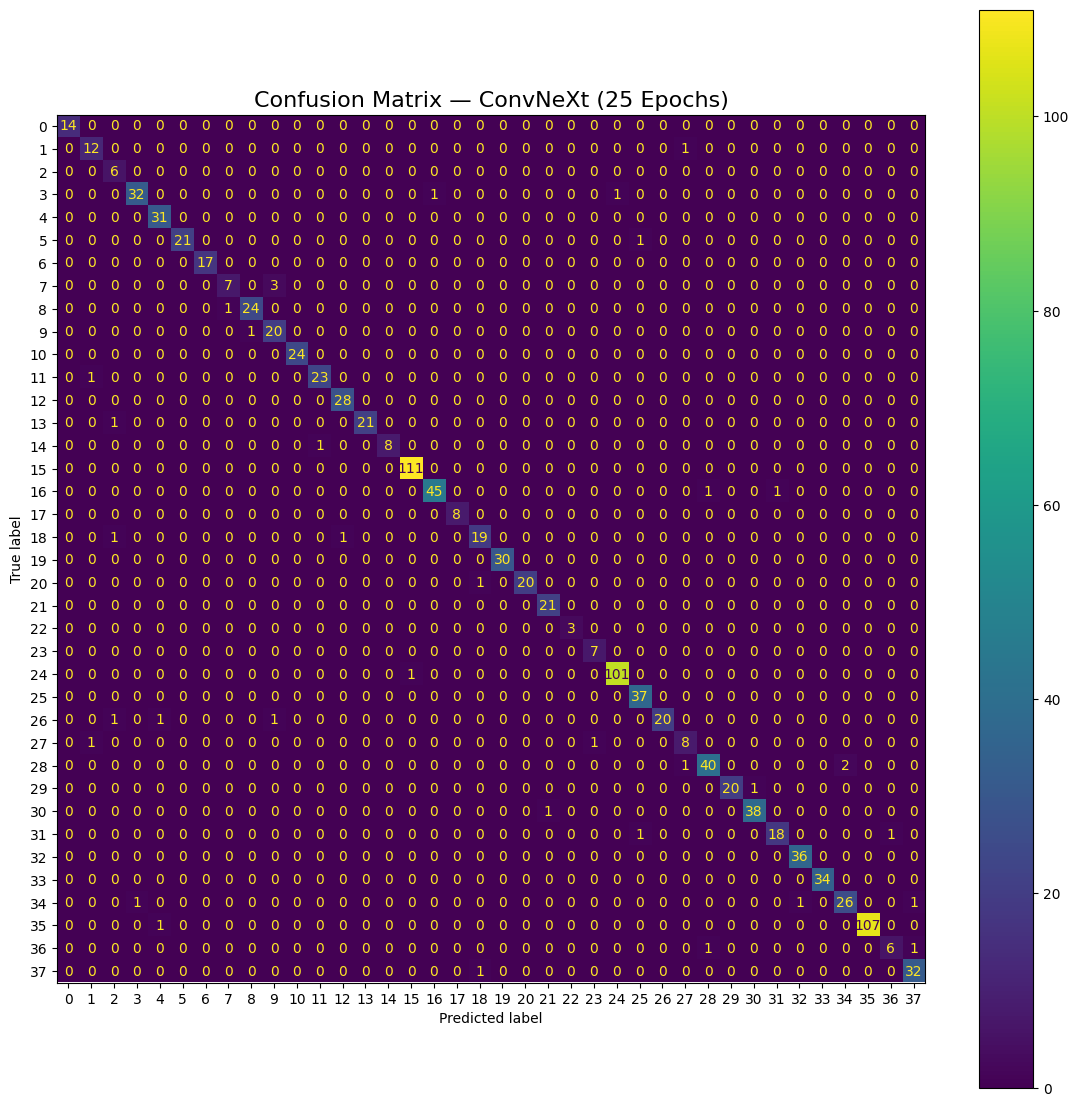

In [22]:
print(f"\n📉 Test Loss      : {test_loss:.4f}")
print(f"🎯 Test Accuracy  : {test_acc:.4f}")
print(f"🔍 Precision      : {precision:.4f}")
print(f"🔁 Recall         : {recall:.4f}")
print(f"🎯 F1 Score       : {f1:.4f}")

# Display confusion matrix with some dignity
os.makedirs("convnext25epochs", exist_ok=True)
cmp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
fig, ax = plt.subplots(figsize=(14, 14))
cmp.plot(ax=ax)
plt.title("Confusion Matrix — ConvNeXt (25 Epochs)", fontsize=16)
plt.savefig("convnext25epochs/confusionmatrix.png")
plt.show()

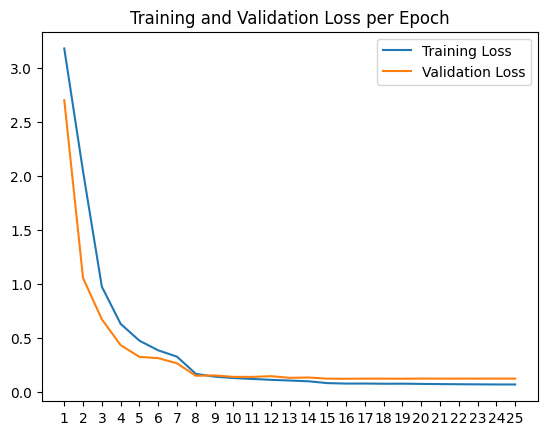

In [23]:
# Plot losses
epochs = [i for i in range(1, num_epochs + 1)]
plt.plot(epochs, losses['train'], label="Training Loss")
plt.plot(epochs, losses['val'], label="Validation Loss")
plt.xticks(epochs)
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.savefig('convnext25epochs/loss.png')
plt.show()

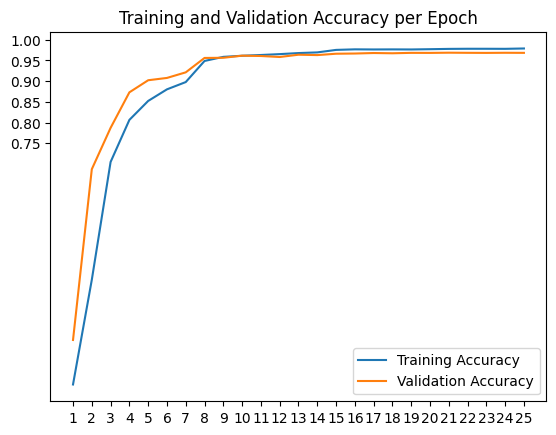

In [24]:
# Plot accuracies
epochs = [i for i in range(1, num_epochs + 1)]
plt.plot(epochs, accs['train'], label="Training Accuracy")
plt.plot(epochs, accs['val'], label="Validation Accuracy")
plt.xticks(epochs)
plt.yticks(np.arange(0.75, 1.02, 0.05))
plt.title("Training and Validation Accuracy per Epoch")
plt.legend()
plt.savefig('convnext25epochs/accuracy.png')
plt.show()

In [25]:
def predict_image(model, image_path):
    model.eval()

    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ])

    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        _, pred = torch.max(output, 1)

    actual_class = image_path.split("/")[-2]
    predicted_class = distinct_labels[pred.item()]
    print(f"Actual Class: {actual_class}")
    print(f"Predicted Class: {predicted_class}")

    # Show image
    plt.imshow(np.array(image))
    plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}")
    plt.axis('off')
    plt.show()

Actual Class: Apple___Apple_scab
Predicted Class: Apple___Apple_scab


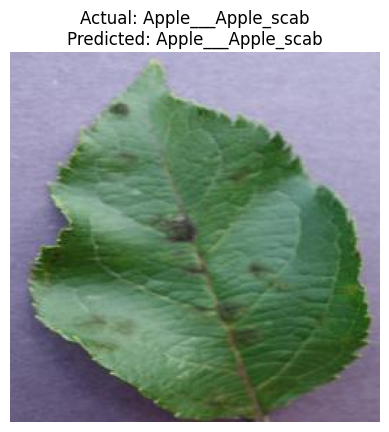

In [26]:
predict_image(model, "/kaggle/input/plantvillage-dataset/color/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG")

Actual Class: Corn_(maize)___Common_rust_
Predicted Class: Corn_(maize)___Common_rust_


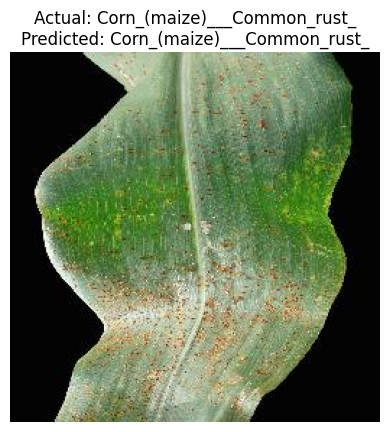

In [27]:
predict_image(model, "/kaggle/input/plantvillage-dataset/color/Corn_(maize)___Common_rust_/RS_Rust 1567.JPG")